<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Tutorial%20for%20SMT%20based%20Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for SMT based Neural Network Verification

As an example we try to verifiy the **robustness** of a classification Network trained on the iris dataset. We learn how to train a small neural network in pytorch and use the weights and biases to create a number of terms and formulas.



In [1]:
!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/iris_trainer.py'}
import iris_trainer

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/plots.py'}
import plots

from torch import nn

# numpy
import numpy as np

# for plots
import matplotlib.pyplot as plt

# for measuring runtime
import time

# SMT solver
%pip install z3-solver
from z3 import *

--2022-05-25 08:16:04--  https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/iris_trainer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2934 (2.9K) [text/plain]
Failed to rename iris_trainer.py to iris_trainer.py.1: (2) No such file or directory
Saving to: ‘iris_trainer.py’

iris_trainer.py     100%[===================>]   2.87K  --.-KB/s    in 0s      

2022-05-25 08:16:04 (36.2 MB/s) - ‘iris_trainer.py’ saved [2934/2934]

--2022-05-25 08:16:10--  https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/plots.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (ra

<a id='header_training'></a>
## Training of Neural Network

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [3]:
names, feature_names, X, y, X_scaled, X_train, X_test, y_train, y_test = iris_trainer.load_dataset()

model = iris_trainer.train_model(
    NeuralNetwork(input_dim=X_train.shape[1], output_dim=3, number_of_neurons=20), 
    epochs=100, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test)

Shape of X (data): (150, 4)
Shape of y (target): (150,) int64
Example of x and y pair: [5.1 3.5 1.4 0.2] 0
Shape of training set X (120, 4)
Shape of test set X (30, 4)


100%|██████████| 100/100 [00:00<00:00, 591.39it/s]


Done. Accuracy: 0.9


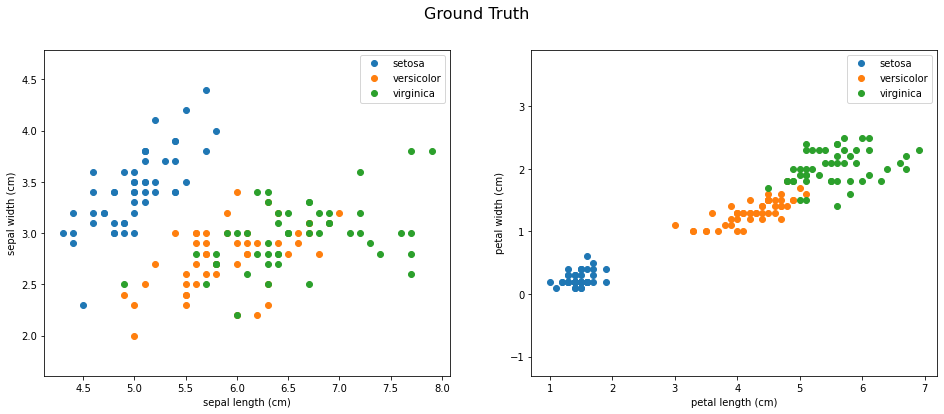

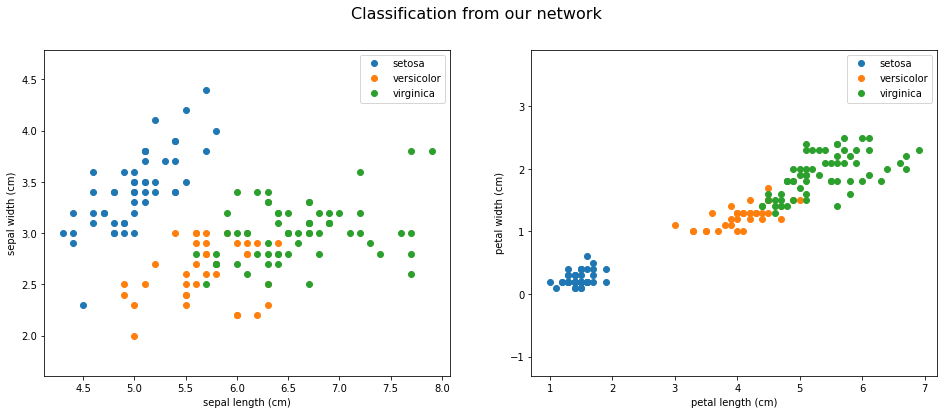

In [5]:
plots.show_plots(names, feature_names, X, y, title = 'Ground Truth')
plots.show_plots(names, feature_names, X, iris_trainer.predict(X_scaled, model), title = 'Classification from our network')

## Define Coditions for Robustness

### Pre Condition



In [11]:
fixed_input_y = X_scaled[0]
fixed_input_y_class = y[0]
epsilon = 0.5

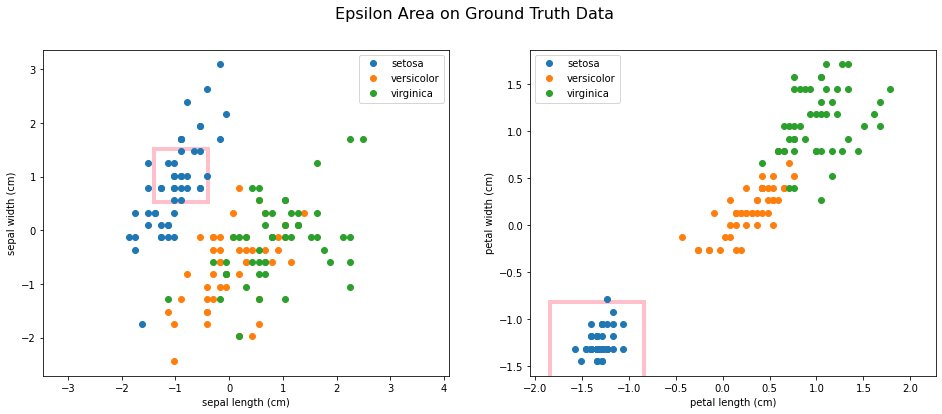

In [12]:
plots.show_plots(names, feature_names, X_scaled, y, fixed_input_y, epsilon, title = 'Epsilon Area on Ground Truth Data')

In [7]:
input_size = fixed_input_y.shape[0]
x = RealVector("x", input_size)

and_parts = []
for i, x_vi in enumerate(x):
  and_parts.append(And((x_vi - fixed_input_y[i]) <= epsilon, (fixed_input_y[i] - x_vi) <= epsilon))
pre_cond = And(and_parts)

In [14]:
print(pre_cond)

And(And(x__0 - -9006811702978099/10000000000000000 <= 1/2,
        -9006811702978099/10000000000000000 - x__0 <= 1/2),
    And(x__1 - 2038008703943213/2000000000000000 <= 1/2,
        2038008703943213/2000000000000000 - x__1 <= 1/2),
    And(x__2 - -2680453053245527/2000000000000000 <= 1/2,
        -2680453053245527/2000000000000000 - x__2 <= 1/2),
    And(x__3 - -13154442950077407/10000000000000000 <= 1/2,
        -13154442950077407/10000000000000000 - x__3 <= 1/2))


### Post Condition

In [16]:
model_parameters = [param.cpu().detach().numpy() for param in model.parameters()]
weights = model_parameters[0::2]
output  = [RealVector(f"x{i}", weight.shape[0]) for i, weight in enumerate(weights)]

In [17]:
# post-condition
# x_vo = x_v'
and_parts = []
for i, x_vo in enumerate(output[-1]):
  # l is the argmax of fixed_input_y
  and_parts.append(x_vo <= output[-1][fixed_input_y_class])
post_cond = And(and_parts)

In [18]:
print(post_cond)

And(x2__0 <= x2__0, x2__1 <= x2__0, x2__2 <= x2__0)


## Defining the Assignment

Next we create a solver in order to find Aversarial Examples. "An adversarial example is an instance with small, intentional feature perturbations that cause a machine learning model to make a false prediction." (For more information on adversarial examples see [this article](https://christophm.github.io/interpretable-ml-book/adversarial.html).

We use Z3 in this Tutorial. Z3 is a theorem prover from Microsoft Research (for more information on z3 see [z3 on pypi](https://pypi.org/project/z3-solver/)). 

**Two different approaches** to create formulas are explained in this tutorial. You can just use the one more interesting to you or try both. The ML model was trained on the iris dataset in the previous section. Now we recreate the model using the trained weights and the layers of the model.

---

In both cases we start with extracting the learned weights and biases from the model. This is done by iterating over the layers and saving the weights and biases of the Linear Layers into lists.

In [19]:
model_parameters = [param.cpu().detach().numpy() for param in model.parameters()]
weights = model_parameters[0::2]
biases = model_parameters[1::2]

### Approach 1: Black Box

Like we explained in the first part [(Training of Neural Network)](#header_training) only fully connected layer with the Relu activation function are used in the networks we are trying to test on robustness.



In [1]:
def Relu(x):
    return np.vectorize(lambda y: If(y >= 0 , y, RealVal(0)))(x)
  
def Abs(x):
    ret = If(x <= 0, -x, x)
    return ret

In [2]:
def net(x, weights, biases):
  output = x

  for i, (weight, bias) in enumerate(zip(weights, biases)):
    output = weight @ output + bias
    # apply relu except in last layer
    if i != len(weights) - 1:
      output = Relu(output)
  return output

In [ ]:
assign = [x_vo <= output[fixed_input_y_class]]

### Approach 2: Encode each neuron individually

In [20]:
def ReluSingleNeuron(x):
  return If(x >= 0, x, RealVal(0))

In [23]:
# assign
assign_parts = []
# for each layer
for layer_i, (layer_output, layer_weights, layer_biases) in enumerate(zip(output, weights, biases)):
  # for each neuron
  for neuron_output, neuron_weights, neuron_bias in zip(layer_output, layer_weights, layer_biases):
    if layer_i == 0:
      # neuron input is net input
      neuron_inputs = x
    else:
      # neuron input is output of previous layer
      neuron_inputs = output[layer_i - 1]
    assign_parts.append(neuron_output == ReluSingleNeuron(neuron_weights @ neuron_inputs + neuron_bias))
assign = And(assign_parts)

In [24]:
print(assign_parts[0])

x0__0 ==
If(565168559551239/1000000000000000*x__0 +
   6880897283554077/100000000000000000*x__1 +
   4803081452846527/10000000000000000*x__2 +
   -2045958861708641/25000000000000000*x__3 +
   5452609/10000000 >=
   0,
   565168559551239/1000000000000000*x__0 +
   6880897283554077/100000000000000000*x__1 +
   4803081452846527/10000000000000000*x__2 +
   -2045958861708641/25000000000000000*x__3 +
   5452609/10000000,
   0)


## Verifying robustness

In [ ]:
# verification conditions
verification_cond = Implies(And(pre_cond, assign), post_cond)

# prove using Z3
prove(verification_cond)

TIP: This verification could take a long time depending on how big your network is. You will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it's VMs if you are idle for too long (30-90 mins).

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit **Enter**
```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```
Looks like this, it will click the screen every 10 minutes so that you don't get kicked off for being idle! HACKS!